# Data Mining - Age Classification through Transfer Learning (Appendix 1)

#### Based on [https://www.tensorflow.org/tutorials/images/transfer_learning?hl=en]

In this Appendix 1 notebook, we show our previous attempts at building a model through the use of Transfer Learning for age classification. 

We used an unconventional dataset that later on proved to be not so convenient for our goals, leading us to the possibility of changing dataset, as we did. 

In more detail, the Dataset we chose to use here was the LFW Face Dataset which was originally created for face recognition rather than classification of features. Indeed, most attributes associated with each image were generated by another ML algorithm, that assigned for that attribute of the specific image a difficult to interpret number. We then realised that this fact was hindering out progress, leading to us changing the data we worked with. 

**Note**: most of the notebook is commented as most of it is comprised of commands that must be executed only once; thus, to avoid any mistakes of re-running these commands, we commented them.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
%pylab inline
import pandas as pd
#tf.config.run_functions_eagerly(True)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Loading Drive to access files

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Download Dataset \[ **DO NOT NEED TO EXECUTE** \]

In [4]:
#_URL = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
#path_to_tgz = tf.keras.utils.get_file('lfw.tgz', origin=_URL, extract=True)
#PATH = os.path.join(os.path.dirname(path_to_tgz), 'lfw')

## [PRELIMINARY] Global Parameters & Variables

In [5]:
#Per Andrea
#PATH = '/media/andrea/HDD/Data_Mining/DATASET_BACKUP'
#PATH = '/content/drive/myDrive/Mining_FinalProject/DATASET BACKUP'

#Per Albi
PATH = '../lfw'
#--------------------------
TRAINING = PATH+'/TRAINING'
VALIDATION = PATH+'/VALIDATION'
TEST = PATH+'/TEST'

#Cropped images
CROP_TRAINING = TRAINING+'/cropped'
CROP_VALIDATION = VALIDATION+'/cropped'
CROP_TEST = TEST+'/cropped'

## [PRELIMINARY] Functions ##

Building some function useful functions for manipulating the dataset files and OS directories.

- Removes repeated elements inside a list, returns the cleared list.

In [6]:
def unique(list1):
    return list(set(list1))

- Given a parent folder path, extracts the path of all files inside all subfolders. For each subfolder, a list is created such that the output is a list of lists: if a single list of paths is required, optional flatting is possible.

In [7]:
def get_img_path(path, flatten=False):
       
    paths = []
    for folder,subfolders,file in os.walk(path,topdown=True):
        array = []
        for fname in file:
            full_name=os.path.join(folder,fname)
            array.append(full_name)
        paths.append(array)
        
    if flatten == True:
        flat_paths = [item for items in paths for item in items]
        return flat_paths
    else: 
        return paths

- Move images (list of paths required) to a destination folder.

In [8]:
def move_imgs(path_image, dest_path):
    """
    Function that moves one or more images for which path is provided, to the directory of choice.
    
    path_image: string or list of strings. Path of the images to be moved.
    dest_path: string. Path of the final directory. If it already exists, 
    it will be removed with its content and a new one will be created in its place.

    Returns:
    None
    """
    import shutil
    import os
    
    #creo una nuova cartella all'interno del dataset flw
    new_dir=dest_path
    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)
    os.mkdir(new_dir)
    
    #copio i file selezionati nella nuova cartella
    for i in path_image:
        shutil.copy(i, new_dir)
    
    

- MTCNN: identifies faces from images and extracts them. It then resizes the extracted images to the desired size. The source code has been edited to adapt it for our specific case and needs (adding a resize feature, and some overwriting controls).

    Source: https://stackoverflow.com/questions/65105644/how-to-face-extraction-from-images-in-a-folder-with-mtcnn-in-python

In [9]:
from mtcnn import MTCNN
import cv2
import os
from PIL import Image
import sys
import shutil

def crop_image(size, source_dir, dest_dir, mode, overwrite = True):
    if os.path.isdir(dest_dir)==False:
        os.mkdir(dest_dir)
    else:
        if overwrite == True:
            choice = input("Are you sure you want to overwrite? [Y/N]:")
            if choice == 'Y':
                shutil.rmtree(dest_dir)
                os.mkdir(dest_dir)
            else:
                print('Then change parameters...')
                sys.exit(0)        
        else:
            pass
    detector = MTCNN()
    #source_list=os.listdir(source_dir)
    #Evaluating all paths(images) to be copied
    initial_list=[i for i in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, i))]    
    #Decide whether to crop them all again, or just the missing ones
    if overwrite == True:
        source_list = initial_list
    else:
        #Evaluating all the images already copied
        existing_list = [i for i in os.listdir(dest_dir) if os.path.isfile(os.path.join(dest_dir, i))]
        #Creating a differential list, so as to crop and store missing images only
        diff_list = list(set(initial_list).difference(existing_list))
        source_list = diff_list
        print(len(source_list), 'missing files')
        
    uncropped_file_list=[]
    for f in source_list:
        print(f)
        f_path=os.path.join(source_dir, f)
        dest_path=os.path.join(dest_dir,f)
        img=cv2.imread(f_path)
        data=detector.detect_faces(img)
        if data ==[]:
            uncropped_file_list.append(f_path)
        else:
            if mode==1:  #detect the box with the largest area
                for i, faces in enumerate(data): # iterate through all the faces found
                    box=faces['box']  # get the box for each face                
                    biggest=0                    
                    area = box[3]  * box[2]
                    if area>biggest:
                        biggest=area
                        bbox=box 
                bbox[0]= 0 if bbox[0]<0 else bbox[0]
                bbox[1]= 0 if bbox[1]<0 else bbox[1]
                img=img[bbox[1]: bbox[1]+bbox[3],bbox[0]: bbox[0]+ bbox[2]] 
                # resize pixels to the model size
                image = Image.fromarray(img)
                image = image.resize((size, size))
                face_array = asarray(image)
                cv2.imwrite(dest_path, face_array)
            else:
                for i, faces in enumerate(data): # iterate through all the faces found
                    box=faces['box']
                    if box !=[]:
                        # return all faces found in the image
                        box[0]= 0 if box[0]<0 else box[0]
                        box[1]= 0 if box[1]<0 else box[1]
                        cropped_img=img[box[1]: box[1]+box[3],box[0]: box[0]+ box[2]]
                        # resize pixels to the model size
                        image = Image.fromarray(img)
                        image = image.resize((size, size))
                        face_array = asarray(image)
                        fname=os.path.splitext(f)[0]
                        fext=os.path.splitext(f)[1]
                        fname=fname + str(i) + fext
                        save_path=os.path.join(dest_dir,fname )
                        cv2.imwrite(save_path, face_array)  
                        
    print(len(uncropped_file_list), 'files have not been processed')
    return uncropped_file_list

The "active" code that actually launches MTCNN. It asks which images and where the cropped ones should be stored. If desired, it returns a list of the pictures for which face extraction failed.

In [10]:
def crop_and_resize(source_dir, dest_dir, size = 160, uncropped_list = False, overwrite = True):
    import os
    import shutil
    
    source_dir=source_dir
    dest_dir=dest_dir # directory where cropped images get stored
    size=size
    #Remove destination folder and then create a new one
    #this way, function does not raise error if folder already exists
    
    
    uncropped_files_list = crop_image(size, source_dir, dest_dir, 1, overwrite=overwrite) # mode=1 means 1 face per image
    if uncropped_list == True:
        return uncropped_files_list
    

## Data & Pre-processing

Attributes (and labels) associated with each image are contained in a tabbed file *"lfw_attributes_nohead.txt"*. We load it in a Pandas DataFrame

In [11]:
import pandas as pd
#!head /lfw_attributes.txt #mi da il contenuto delle prime 10 linee del file
#creo il dataframe con gli attributi
#---------------------
#Andre
#df_attribute = pd.read_csv('/media/andrea/HDD/Data_Mining/lfw_attributes_nohead.txt', delimiter="\t")
#Albi
df_attribute = pd.read_csv('../lfw_attributes_nohead.txt', delimiter="\t")

In [12]:
#liste con labels che ci interessano
label_baby=df_attribute['Baby']
label_child=df_attribute['Child']
label_youth=df_attribute['Youth']
label_middle=df_attribute['Middle Aged']
label_senior=df_attribute['Senior']

### Custom Train/Validation/Test Shuffle

All images of the datasets are shuffled in order to construct a new Training/Test Split. Before proceding on this line of work, we tried to use the split suggested by the authors, which we found to be either faulty or made for another task: indeed, the Training set provided by the authors of the dataset has many duplicated images, totaling to only $\sim$ 3400 instead of the 4400 we thought initially. Furthermore, having access to more than 12000 images and restricting ourselves to the nominal 4400 did not seem convenient for learning purposes. 

For more information on how we trated the suggested split, see *Option 1* at the bottom of this notebook.

------------------------------------------------------------------------------

Creating a compilation of paths to each image. The output is a list of lists (one for each person in the dataset, inside of which images' names are stored).

\[ **DO NOT NEED TO EXECUTE** \]

In [13]:
#compilation = get_img_path(PATH, flatten=False)

Let's split into Training and Test set. To do this, we just separate into a 80/10/10 percentage on AUTHORS. In doing so, we make sure that each person either appears in the Training Set or in the Test Set such that performance is not being falsified, since part of the Fine Tuning is about learning facial features and, even though pictures of the same person might have been taken in different ages the network would be prone to "remembering" rather than doing inference if a person appears both in training and in test. Also, multiple images of the same person in the training can be regarded as Data Augmentation (but we must be careful with bias if there are outliers that have many more pictures than most people, in that case we wither uniform the dataset with data augmentation on the average, or remove some pictures of the outliers).


Let's see whether there are outliers, keeping into account that for each person there are about 4 images on average.

\[ **DO NOT NEED TO EXECUTE** \]

In [14]:
#Max number or images per person
#highest = 0
#person = ''
#for pers in compilation: 
#    num = len(pers)-1 #-1 perché su windows per qualche motivo mi tira fuori un elemento in più, un link al Desktop
#    #print(num)
#    if (num > highest): 
#        highest = num
#        person = pers
#
#print(highest)
#person
#
##Highest number of images is 530 for George W Bush#
#   

We see that there is at least one outlier (George W. Bush) who have much more images than the other people. The idea here would be to cut the images for outliers to the average number of images per person. We did not proceed on this step as we figured we had to change dataset for bigger issues.

For Validation & Test people with just a single image are selected. Ideally, we want one image per person so that Generalization Error is evaluated without repetitions. We then leave multiple images per person ("Data Augmentation") inside the Training Set.

\[ **DO NOT NEED TO EXECUTE** \]

In [15]:
#from copy import deepcopy
#import random
#
##Percentage Split
#split = 0.1
#
##Copying list BY VALUE
#compilation_aux = deepcopy(compilation)
#
##Shuffling people
#random.shuffle(compilation_aux)
#threshold = round(len(compilation)*split)
#
##10% Test
#test_path = []
#validation_path = []
##j = 0
#for i in range(1, highest):
#    #j = i
#    for pers in compilation_aux: 
#        if len(test_path) == threshold:
#            break
#        if (len(pers) == i):
#            test_path.append(pers)
#            compilation_aux.remove(pers)
#            #print(len(test))
#
##10% Validation
#for k in range(1, highest):
#    for pers in compilation_aux: 
#        if len(validation_path) == threshold:
#            break
#        if (len(pers) == k):
#            validation_path.append(pers)
#            compilation_aux.remove(pers)
#            #print(len(validation))
#            
#print(len(test_path), len(validation_path))
#
##80% Training
#training_path = compilation_aux

With this code, we created 3 shuffled lists of paths, one for each of Training/Validation/Test.
Let's gather images in appropriate folders in order to physically split them, allowing us to create Tensorflow Datasets. 

Flattening path lists, in order to obtain a single list rather than a list of lists.

\[ **DO NOT NEED TO EXECUTE** \]

In [16]:
#flat_training_path = [item for items in training_path for item in items]
#flat_validation_path = [item for items in validation_path for item in items]
#flat_test_path = [item for items in test_path for item in items]

In [17]:
#Once this paragraph is run once, we can just obtain the same results by calling these functions
training_path = get_img_path(TRAINING, flatten = True)
validation_path = get_img_path(VALIDATION, flatten = True)
test_path = get_img_path(TEST, flatten = True)

\[ **DO NOT NEED TO EXECUTE** \]

Moving images in the correct subfolder, one for each split.

In [18]:
#Training
#move_imgs(flat_training_path, TRAINING)
#
#Validation
#move_imgs(flat_validation_path, VALIDATION)
#
#Test
#move_imgs(flat_test_path, TEST)

To extrapolate faces, MTCNN is applied. In this way, the network does not have to learn backgrounds and by concentrating on faces only should have improved performances. 

Cropped images all have different shapes. We need to normalize shapes to a standard input shape that will be then provided to the network. The chosen shape is the standard one required from the network we are using: 160x160. A piece of code is added to the MTCNN block so that images are resized before being extracted.

\[ **DO NOT NEED TO EXECUTE** \]

In [19]:
#Training
#f = crop_and_resize(TRAINING, CROP_TRAINING, size = 160, uncropped_list = True, overwrite=False)

\[ **DO NOT NEED TO EXECUTE** \]

In [20]:
#Validation
#h = crop_and_resize(VALIDATION, CROP_VALIDATION, size = 160, uncropped_list = True, overwrite=False)
#h

\[ **DO NOT NEED TO EXECUTE** \]

In [21]:
#Test
#g = crop_and_resize(TEST, CROP_TEST, size = 160, uncropped_list = True, overwrite=False)
#g

### Datasets Creation

Now, we need to join attributes to each picture in order to associate images and labels so that the effective datasets can be created.

We start by creating the list of paths of the extracted (cropped) faces.

In [22]:
crop_path_test = get_img_path(CROP_TEST, flatten = True)
crop_path_validation = get_img_path(CROP_VALIDATION, flatten = True)
crop_path_training = get_img_path(CROP_TRAINING, flatten = True)

Now, we create a function that given a list of paths, creates an auxiliary dataframe (*df_img*) that includes the paths of images and is formatted such that we have the same keys ('person', 'imagenum') as the attributes' dataframe. The idea is to join them on the keys, in order to retrieve immediately image and label and thus creating the effective Dataset.

In [23]:
def img_df(path_list):
    paths = path_list
    df_img = pd.DataFrame()
    
    #For each image in the list
    for img in paths: 
        #Filename without extension
        fname = os.path.basename(img).replace('.jpg','')
        #Extrapolate the image number
        num = int(fname.rsplit('_', 1)[1])
        #Extrapolate the person name
        name = fname.rsplit('_', 1)[0].replace('_', ' ')
        
        #Adding all into a dataframe
        df_img = df_img.append({"person": name, "imagenum": num, "path": img}, ignore_index=True)
    
    return df_img

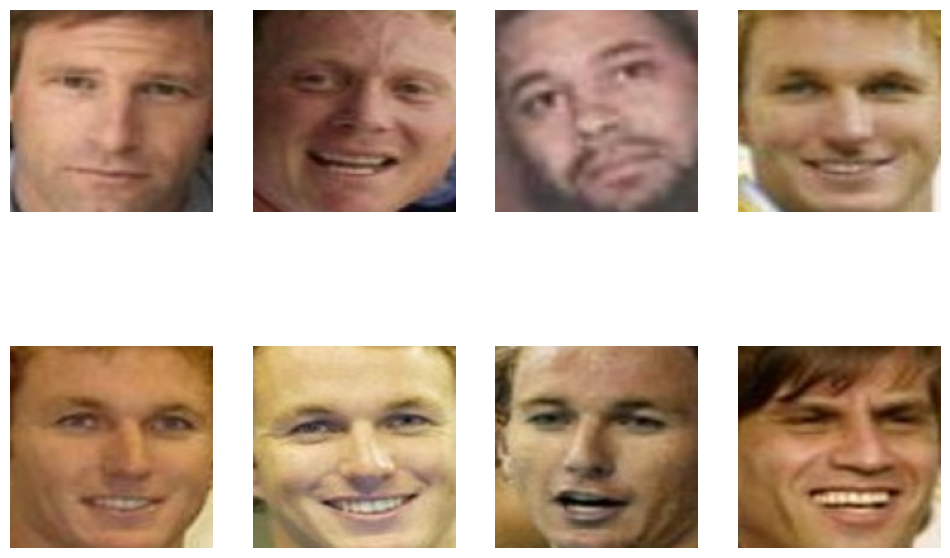

In [24]:
import matplotlib.style as style

nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(crop_path_training[i]))
    #plt.title(y_train[i], size=10)
    plt.axis('off')

Creating such dataframes for each split.

In [ ]:
df_test = img_df(crop_path_test)
df_val = img_df(crop_path_validation)
df_train = img_df(crop_path_training)

Merging the image dataframe with the attributes dataframe. We need to cast the imagenum key type.

In [26]:
df_test['imagenum'] = df_test['imagenum'].astype('int32')
df_val['imagenum'] = df_val['imagenum'].astype('int32')
df_train['imagenum'] = df_train['imagenum'].astype('int32')

In [27]:
df_test = pd.merge(df_test, df_attribute, on=['person','imagenum'])
df_val = pd.merge(df_val, df_attribute, on=['person','imagenum'])
df_train= pd.merge(df_train, df_attribute, on=['person','imagenum'])

We now extract the 5D label. By obesrving the labels, it seems that the highest label of the 5 possible is the correct one. In order to work with a set of labels that allows for a classification task, we transformed the label in a one-hot-encoding style, giving 1 to what seems to be the best prediction.

In [28]:
val = []
for i in range(0,len(df_val['Child'])):
    a = []
    a.append(df_val['Baby'][i])
    a.append(df_val['Child'][i])
    a.append(df_val['Youth'][i])
    a.append(df_val['Middle Aged'][i])
    a.append(df_val['Senior'][i])
    #if one-hot-encoding
    b=max(a)
    for j in range(0,len(a)):
        if(a[j]==b):
            a[j]=1
        else:
            a[j] = 0
    val.append(a)
    
val_lab = np.array(val)

In [29]:
val_lab

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]])

In [30]:
train = []
for i in range(0,len(df_train['Baby'])):
    a = []
    a.append(df_train['Baby'][i])
    a.append(df_train['Child'][i])
    a.append(df_train['Youth'][i])
    a.append(df_train['Middle Aged'][i])
    a.append(df_train['Senior'][i])
    #if one-hot-encoding
    b=max(a)
    for j in range(0,len(a)):
        if(a[j]==b):
            a[j]=1
        else:
            a[j] = 0
    train.append(a)
    
train_lab = np.array(train)

In [31]:
test = []
for i in range(0,len(df_test['Baby'])):
    a = []
    a.append(df_test['Baby'][i])
    a.append(df_test['Child'][i])
    a.append(df_test['Youth'][i])
    a.append(df_test['Middle Aged'][i])
    a.append(df_test['Senior'][i])
    #if one-hot-encoding
    b=max(a)
    for j in range(0,len(a)):
        if(a[j]==b):
            a[j]=1
        else:
            a[j] = 0
    test.append(a)
    
test_lab = np.array(test)

We create the Datasets for training, test and validation. We extract the images as vectors and create a list of the images associated with the labels. Then we merge the images and labels into a dataset.

In [32]:
BATCH_SIZE = 64

In [33]:
image_val = []
for im in range(0,len(df_val['path'])):
    
    image_string = tf.io.read_file(df_val['path'][i])
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string)
    image_val.append(image_decoded)

In [34]:
val = tf.data.Dataset.from_tensors((image_val,val_lab)).unbatch().batch(BATCH_SIZE)

In [35]:
image_train = []
for im in range(0,len(df_train['path'])):
    
    image_string = tf.io.read_file(df_train['path'][i])
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string)
    image_train.append(image_decoded)

In [36]:
train = tf.data.Dataset.from_tensors((image_train,train_lab)).unbatch().batch(BATCH_SIZE)

In [37]:
image_test = []
for im in range(0,len(df_test['path'])):
    
    image_string = tf.io.read_file(df_test['path'][i])
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string)
    image_test.append(image_decoded)

In [38]:
test = tf.data.Dataset.from_tensors((image_test,test_lab)).unbatch().batch(BATCH_SIZE)

In [39]:
train

<BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 5), dtype=tf.int32, name=None))>

## Loading pre-trained model

Loading the pre-trained model MobileNetV2 on *Imagenet* dataset. By specifying the include_top=False argument, the model won't include the classification layers at the top, which allows for better feature extraction. 


"This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model."

In [40]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 

In [41]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

## Transfer Learning

### Step 1 - Feature Extraction

We freeze the network weights. In this way, we can use the already-learnt weights and train only the classifier on top.

In [42]:
base_model.trainable = False

#### Adding a classificator on top

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [43]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

tf.keras.layers.Dense layer to convert these features into a single prediction per image. In order to constrain the prediction, we chose a function that saturates to 1 and allows for categorization.

Since originally attributes were valued between [-3,+3], tried to use a rescaled tanh function in order to get negative numbers as well.

In [44]:
#def scaled_tanh(x, alpha):
 #   tanh = tf.keras.activations.tanh(x/alpha)
  #  return alpha*tanh

#alpha=3 
#scaled_activation = lambda x: scaled_tanh(x, alpha=alpha)

In [45]:
prediction_layer = tf.keras.layers.Dense(5, activation = 'softmax')

We now effectively build the model, adding the new layers on top.

In [47]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it.

Since we have multilabel prediction to make, and they are in one-hot encoding format, the chosen Loss is the CategoricalCrossEntropy. Adam is the optimizer we chose in order to minimize said Loss.

In [51]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'],
              )

In [146]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

### Train the model

In [52]:
initial_epochs = 10
history = model.fit(train,
                    epochs=initial_epochs,
                    validation_data=val
                   )

Epoch 1/10
182/182 [==============================] - 50s 265ms/step - loss: 1.5636 - accuracy: 0.3002 - val_loss: 1.6392 - val_accuracy: 0.2724
Epoch 2/10
182/182 [==============================] - 49s 270ms/step - loss: 1.5218 - accuracy: 0.3074 - val_loss: 1.6169 - val_accuracy: 0.2724
Epoch 3/10
182/182 [==============================] - 49s 272ms/step - loss: 1.5076 - accuracy: 0.3055 - val_loss: 1.6137 - val_accuracy: 0.2724
Epoch 4/10
182/182 [==============================] - 50s 274ms/step - loss: 1.4977 - accuracy: 0.3072 - val_loss: 1.5911 - val_accuracy: 0.2724
Epoch 5/10
182/182 [==============================] - 48s 266ms/step - loss: 1.4875 - accuracy: 0.3117 - val_loss: 1.5517 - val_accuracy: 0.2724
Epoch 6/10
182/182 [==============================] - 50s 276ms/step - loss: 1.4767 - accuracy: 0.3074 - val_loss: 1.5504 - val_accuracy: 0.2724
Epoch 7/10
182/182 [==============================] - 49s 268ms/step - loss: 1.4782 - accuracy: 0.3108 - val_loss: 1.5573 - val_ac

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

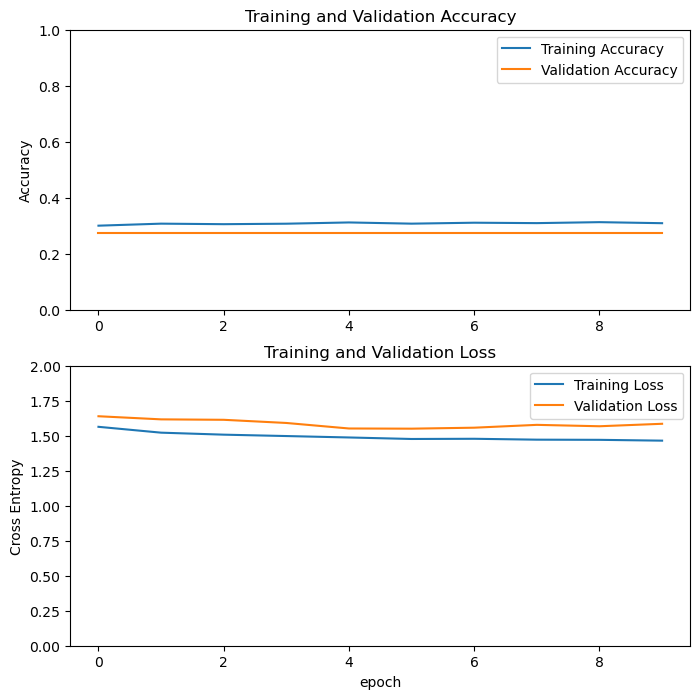

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

As we can see, the model does not seem to learn anything as it starts and remains on a plateau.

## Fine tuning

We now try to fine-tune some of the base model layers as well, to see if this brings some improvements. In order to do so we unfreeze the base model weights, up to a certain depth. For example, we decided to see what happens if we start the fine tuning process from the 80th layer.

In [59]:
base_model.trainable = True

In [60]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

In [61]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [62]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val)

Epoch 10/20
182/182 [==============================] - 83s 436ms/step - loss: 1.4113 - accuracy: 0.3176 - val_loss: 1.4126 - val_accuracy: 0.2724
Epoch 11/20
182/182 [==============================] - 79s 437ms/step - loss: 1.3769 - accuracy: 0.3240 - val_loss: 1.4225 - val_accuracy: 0.2724
Epoch 12/20
182/182 [==============================] - 78s 430ms/step - loss: 1.3954 - accuracy: 0.3254 - val_loss: 1.4240 - val_accuracy: 0.2888
Epoch 13/20
182/182 [==============================] - 79s 437ms/step - loss: 1.3994 - accuracy: 0.3115 - val_loss: 1.4120 - val_accuracy: 0.2888
Epoch 14/20
182/182 [==============================] - 79s 433ms/step - loss: 1.3902 - accuracy: 0.3169 - val_loss: 1.4123 - val_accuracy: 0.2888
Epoch 15/20
182/182 [==============================] - 79s 432ms/step - loss: 1.3911 - accuracy: 0.3126 - val_loss: 1.4114 - val_accuracy: 0.2888
Epoch 16/20
182/182 [==============================] - 77s 426ms/step - loss: 1.3886 - accuracy: 0.3157 - val_loss: 1.4114 -

In [63]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

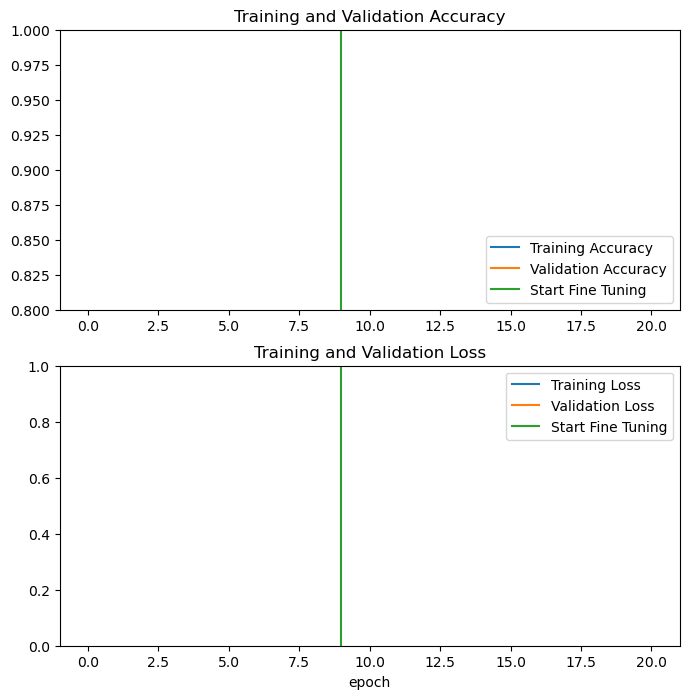

In [64]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [67]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

9/9 [==============================] - 2s 238ms/step - loss: 1.3539 - accuracy: 0.3077
Test accuracy : 0.3076923191547394


## Appendix 1.1 - Authors' Training/Validation/Test split

The [LFW](http://vis-www.cs.umass.edu/lfw/#resources) Dataset comes with a set of folders, one for each person, and each containing several pictures of that same person.

On the website there are 3 files: [Training](http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt), [Test](http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt) and [Attributes](https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt).

We need to extract these data in dataframes and associate images and attributes. 


The extraction is presented below, while the association of attributes has been already shown in the main corpus of this notebook.

----------------------------------------------------------

Loading Datasets into Dataframes

In [ ]:
#Albi
df_train = pd.read_csv('PairsDevTrain_full.txt', delimiter="\t")
df_test = pd.read_csv('PairsDevTest_full.txt', delimiter="\t")

The images are named after the folder's name and plus an identifying number for the image (eg. 0001). We selected the names of the images that I need to select from the folders. This is because to have training and test data,  we needed to select the images from the various folders. Through a loop, it is decided which folder to enter using the df_train, and then the images that I want to call through the list that I create here, selected.
Since the format of these files is inconsisten some awkward code was necessary to complete the task

In [ ]:
train_im = []
for i in range(len(df_train['Folder'])):
    #image1
    if(0<df_train['image1'][i]<10):
        train_im.append(df_train['Folder'][i]+'_000'+str(df_train['image1'][i])+'.jpg')
    if(10<=df_train['image1'][i]<100):
        train_im.append(df_train['Folder'][i]+'_00'+str(df_train['image1'][i])+'.jpg')
    if(100<=df_train['image1'][i]<1000):
        train_im.append(df_train['Folder'][i]+'_0'+str(df_train['image1'][i])+'.jpg')
    if(1000<=df_train['image1'][i]):
        train_im.append(df_train['Folder'][i]+'_'+str(df_train['image1'][i])+'.jpg')
    #image2
    if(0<df_train['image2'][i]<10):
        train_im.append(df_train['Folder'][i]+'_000'+str(df_train['image2'][i])+'.jpg')
        #print(df_train['image2'][i])
    if(10<=df_train['image2'][i]<100):
        train_im.append(df_train['Folder'][i]+'_00'+str(df_train['image2'][i])+'.jpg')
    if(100<=df_train['image2'][i]<1000):
        train_im.append(df_train['Folder'][i]+'_0'+str(df_train['image2'][i])+'.jpg')
    if(1000<=df_train['image2'][i]):
        train_im.append(df_train['Folder'][i]+'_'+str(df_train['image2'][i])+'.jpg')

As mentioned at the beginning of the document, some images are repeated. We use the unique custom function to select only one image if the same is repeated.

In [ ]:
train_im = unique(train_im)

now we create a path to the training images and use it to retrieve them from their folders and copy them to the training folders.

In [ ]:
path_train = []

for folder,subfolders,file in os.walk(PATH,topdown=True):
    #print(folder)
    for fname in file:
        full_name=os.path.join(folder,fname)
        for i in train_im:
            if (fname==i):
                #print(fname)
                path_train.append(full_name)
path_train

In [ ]:
move_imgs(path_train, PATH, 'Training')

Moving on to associate image and labels as shown in the main corpus of the notebook